(1359.301563568345, 61.5090439723249)

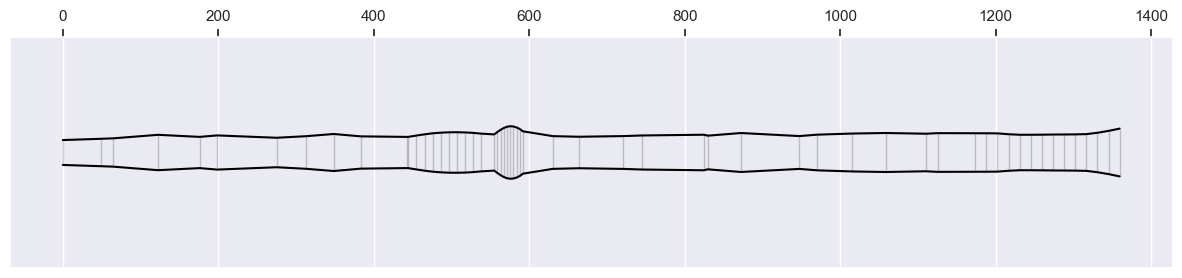

In [42]:
import sys
sys.path.append("../../")

import numpy as np
from scipy.signal import find_peaks
import math
from typing import List
import logging

from didgelab.calc.conv import *
from didgelab.evo.nuevolution import GeoGenome, LossFunction
from didgelab.calc.geo import Geo
from didgelab.calc.sim.sim import get_log_simulation_frequencies, create_segments, compute_impedance
from didgelab.calc.sim.sim import create_segments, compute_impedance, get_notes
from didgelab.evo.nuevolution import Nuevolution, NumpyEncoder, LinearDecreasingCrossover, LinearDecreasingMutation, NuevolutionProgressBar, AdaptiveProbabilities

class WebShape(GeoGenome):

    def __init__(
        self,
        n_segments = 4, 
        d0=32, 
        d_bell_min=50, 
        d_bell_max=70,
        max_length = 1900, 
        min_length = 1500,
        n_bubbles=0,
        smoothness = 0.3,
        bell_accent = 0.3,
        bell_start = 200,
        n_bell_segments = 10
        ):

        self.max_length = max_length
        self.min_length = min_length
        self.n_segments = n_segments
        self.d0 = d0
        self.d_bell_min = d_bell_min
        self.d_bell_max = d_bell_max
        self.n_bubbles = n_bubbles
        self.smoothness = smoothness
        
        self.bubble_width = 200
        self.bubble_height = 20
        
        self.bell_start = bell_start                    # starting the bell bell_start away from the bell end 
        self.bell_accent : float = bell_accent          # the bell will be accentuated by a factor bell_accent
        self.n_bell_segments = n_bell_segments               # the bell will consist of bell_n_segments segments

        self.geo_offset = 3 + self.n_bubbles*3
        genome_length = 3+2*(n_segments-1) + self.n_bubbles*3
        self.n_bubble_segments = 10

        GeoGenome.__init__(self, n_genes = genome_length)

    def get_properties(self):
        length = self.genome[0] * (self.max_length-self.min_length) + self.min_length
        bell_size = self.genome[1] * (self.d_bell_max - self.d_bell_min) + self.d_bell_min
        power = self.genome[2]*4

        bubbles = []
        j=3

        for i in range(self.n_bubbles):
            pos = self.bubble_width + self.genome[j] * (length-2*self.bubble_width)
            width = self.bubble_width*(0.2+self.genome[j+1])/1.2
            height = (0.2+self.genome[j+2])*self.bubble_height/1.2
            j+=3
            bubbles.append((pos, width, height))
            
        x_genome = np.array([self.genome[i] for i in range(self.geo_offset, len(self.genome), 2)])
        y_genome = np.array([self.genome[i] for i in range(self.geo_offset+1, len(self.genome), 2)])

        return length, bell_size, power, x_genome, y_genome, bubbles

    def fix_didge(self, x,y, d0, bellsize):
        mind = d0*0.9
        x=x.copy()
        y=y.copy()
        y[y<mind] = mind
        maxd = bellsize*1.3
        y[y>maxd] = maxd
        return x,y

    def make_bubble(self, x, y, pos, width, height):
        
        bubble_start_x = pos-0.5*width
        bubble_end_x = pos+0.5*width

        if bubble_start_x < 20:
            diff = 20-bubble_start_x
            bubble_start_x += diff
            bubble_end_x += diff

        if bubble_end_x > x[-1]:
            diff = bubble_end_x-x[-1]
            bubble_start_x -= diff
            bubble_end_x -= diff

        bubble_x = np.arange(bubble_start_x, bubble_end_x, (bubble_end_x-bubble_start_x)/self.n_bubble_segments)

        geo = Geo(list(zip(x,y)))
        bubble_y_1 = np.array([geo.diameter_at_x(i) for i in bubble_x])
        bubble_y_2 = height*np.sin(np.pi*np.arange(self.n_bubble_segments)/self.n_bubble_segments)
        bubble_y = bubble_y_1 + bubble_y_2

        y = np.concatenate((y[x<bubble_start_x], bubble_y, y[x>bubble_end_x]))
        x = np.concatenate((x[x<bubble_start_x], bubble_x, x[x>bubble_end_x]))

        return x, y

    def genome2geo(self):
        length, bell_size, power, x_genome, y_genome, bubbles = self.get_properties()

        # create basic conic shape
        x = np.arange(0, 1, 1/(self.n_segments))
        x = np.concatenate((x, [1]))
        x *= length
        
        y = np.arange(0, 1, 1/(self.n_segments))
        y = np.concatenate((y, [1]))
        y = np.power(y, power)
        y = y * (bell_size/(1+self.bell_accent)-self.d0) + self.d0

        # add smoothness / roughness
        shift_x = length / self.n_segments
        x += np.concatenate(([0], (x_genome-0.5)*shift_x, [0]))

        shift_y = (1-self.smoothness)*bell_size
        y += np.concatenate(([0], 0.3*(y_genome-0.5)*shift_y, [0]))

        # add the bell accent
        geo = Geo(list(zip(x,y)))
        bell_start_index = 0
        while x[bell_start_index] < length - self.bell_start:
            bell_start_index += 1

        x_bell = np.arange(self.n_bell_segments, dtype=float)
        x_bell = x_bell[1:]
        x_bell /= max(x_bell)
        x_bell *= self.bell_start
        x_bell += length - self.bell_start

        y_bell = np.array([geo.diameter_at_x(i) for i in x_bell])
        mult = np.arange(len(y_bell), dtype=float)
        mult /= mult[-1]
        mult = np.power(mult, 2)
        mult /= mult[-1]
        mult = 1 + self.bell_accent * np.power(mult, 2)
        y_bell *= mult

        x = np.concatenate((x[0:bell_start_index], x_bell))
        y = np.concatenate((y[0:bell_start_index], y_bell))
        
        x, y = self.fix_didge(x,y,self.d0, bell_size)

        for bubble in bubbles:
            pos, width, height = bubble
            x, y = self.make_bubble(x, y, pos, width, height)

        geo = list(zip(x,y))
        return Geo(geo)

        
geo = WebShape(n_segments = 32, 
    d0=32, 
    d_bell_min=50, 
    d_bell_max=75,
    max_length = 1500, 
    min_length = 1200,
    n_bubbles=2,
    smoothness = 0.5,
    bell_accent = 0.3,
    bell_start = 200,
    n_bell_segments = 15).genome2geo()

from didgelab.util.didge_visualizer import DidgeVisualizer
DidgeVisualizer.vis_didge(geo)
geo.geo[-1]

In [ ]:
# # these target impedances are all tuned to a major scale

# from didgelab.calc.conv import note_to_freq, freq_to_note, note_name, freq_to_note_and_cent
# import pandas as pd

# base_note=-31
# base_freq = note_to_freq(base_note)
# target_freqs = []
# freq = base_freq
# i=0

# scale = [0,2,4,5,7,8,10]

# notes = []
# cent_diffs = []
# while freq < 1000:

#     note = base_note + 12*np.floor(i/len(scale)) + scale[i%len(scale)]
#     freq = note_to_freq(note)
#     note, cent = freq_to_note_and_cent(freq)
#     target_freqs.append(freq)
#     notes.append(note_name(note))
#     cent_diffs.append(cent)
#     i+=1

# target_freqs = np.array(target_freqs)
# target_impedances = 1 - np.arange(len(target_freqs)) / len(target_freqs)
# target_impedances = np.power(target_impedances, 4)
# target_impedances += 0.3
# target_impedances /= target_impedances.max()
# df = pd.DataFrame( {"freq": target_freqs, "note": notes, "cent_diff": cent_diffs, "impedance": target_impedances})
# df['mult'] = df.freq / base_freq
# df.round(2).head(20)

,freq,note,cent_diff,impedance,mult
0,73.42,D2,-0.0,1.00,1.00
1,82.41,E2,-0.0,0.90,1.12
2,92.50,F#2,0.0,0.80,1.26
3,98.00,G2,-0.0,0.72,1.33
4,110.00,A2,0.0,0.65,1.50
5,116.54,A#2,-0.0,0.58,1.59
6,130.81,C3,0.0,0.52,1.78
7,146.83,D3,-0.0,0.47,2.00
8,164.81,E3,-0.0,0.43,2.24
9,185.00,F#3,0.0,0.39,2.52


In [50]:
# these target impedances are multiples

from didgelab.calc.conv import note_to_freq, freq_to_note, note_name, freq_to_note_and_cent
import pandas as pd

base_note=-30
base_freq = note_to_freq(base_note)
target_freqs = []
freq = base_freq
i=1

notes = []
cent_diffs = []
while freq < 1000:
    target_freqs.append(freq)
    i+=1
    freq = base_freq*i
    note, cent = freq_to_note_and_cent(freq)
    notes.append(note_name(note))
    cent_diffs.append(cent)

target_freqs = np.array(target_freqs)
target_impedances = 1 - np.arange(len(target_freqs)) / len(target_freqs)
target_impedances = np.power(target_impedances, 4)
target_impedances += 0.6
target_impedances /= target_impedances.max()
df = pd.DataFrame( {"freq": target_freqs, "note": notes, "cent_diff": cent_diffs, "impedance": target_impedances})
df.round(2)

,freq,note,cent_diff,impedance
0,77.78,D#3,0.00,1.00
1,155.56,A#3,1.96,0.82
2,233.35,D#4,0.00,0.68
3,311.13,G4,-13.69,0.57
4,388.91,A#4,1.96,0.50
5,466.69,C#5,-31.17,0.45
6,544.47,D#5,0.00,0.41
7,622.25,F5,3.91,0.39
8,700.04,G5,-13.69,0.38
9,777.82,A5,-48.68,0.38


In [45]:

class TairuaLoss(LossFunction):

    def __init__(self, target_freqs : List[float], target_impedances : List[float], target_weights : List[float], scale_key : int=None, scale : List[int] =None, scale_weight : float =None, max_error=5):
        self.target_freqs : List[float] = np.log2(target_freqs)
        self.target_impedances : List[float] = target_impedances
        self.target_weights : List[float] = target_weights
        self.max_error : float = 5
        self.freqs : List[float] = get_log_simulation_frequencies(1, 1000, max_error)
        self.scale : int = scale
        self.scale_key : List[int] = scale_key
        self.scale_weight : float = scale_weight

        self.tune_to_scale = False
        if self.scale != None:
            self.scale_freqs : List[float] = self.compute_scale_frequencies()
            self.tune_to_scale = True
    
    # compute the frequencies of all notes of the given scale
    def compute_scale_frequencies(self):
        scale_freqs = []
        freq = -1
        i=0
        while freq<1000:
            f1 = math.floor(i/len(self.scale))
            f2 = i%len(self.scale)
            note = self.scale_key + 12*f1 + self.scale[f2]
            freq = note_to_freq(note)
            i += 1
            scale_freqs.append(freq)

        scale_freqs = np.log2(scale_freqs)
        return scale_freqs

    def loss(self, shape):
        if "loss" in shape.__dict__.keys() and shape.loss is not None:
            return shape.loss
        try:
            geo = shape.genome2geo()
            segments = create_segments(geo)
            impedances = compute_impedance(segments, self.freqs)
            peaks = find_peaks(impedances)

            peak_freqs = np.array([self.freqs[i] for i in peaks[0]])
            peak_freqs = np.log2(peak_freqs)
            peak_impedances = [impedances[i] for i in peaks[0]]
            peak_impedances = np.array(peak_impedances) / impedances.max()

            # compute deviation from tuning table
            tuning_losses = []
            for target_freq, target_impedance in zip(self.target_freqs, self.target_impedances):
                i = np.argmin(np.abs(peak_freqs - target_freq))
                peak_freq = peak_freqs[i]
                peak_impedance = peak_impedances[i]
                diff_freq = cent_diff(target_freq, peak_freq) / 600

                if target_impedance < 0:
                    loss = diff_freq
                else:
                    diff_impedance = peak_impedance - target_impedance
                    loss = np.sqrt(diff_freq*diff_freq + diff_impedance*diff_impedance)
    
                tuning_losses.append(loss)

            tuning_losses = np.abs(tuning_losses)
            tuning_losses = np.sum(tuning_losses * self.target_weights)

            tuning_losses *= 50
            total = np.sum(tuning_losses)

            losses = {
                "tuning_losses": tuning_losses,
            }


            # compute deviation from scale
            if self.tune_to_scale:
                i = [np.argmin(np.abs(self.scale_freqs-freq)) for freq in peak_freqs]
                diffs = np.abs(peak_freqs - self.scale_freqs[i])
                scale_losses = diffs.sum() * self.scale_weight / len(diffs)
                scale_losses *= 10
                total += np.sum(scale_losses)
                losses["scale_losses"] = scale_losses


            losses["total"] = total


            return losses
        except Exception as e:
            logging.exception(e)
            return {
                "total": 100000000,
            }

from didgelab.evo.nuevolution import Nuevolution

freq_weights = 5*np.ones(len(target_freqs))
freq_weights[0] *= 5

imp_weights = 0.1*np.ones(len(target_freqs))
imp_weights[0] *= 5

loss = TairuaLoss(
    target_freqs, 
    [-1] * len(target_freqs),
    freq_weights,
    imp_weights
)

shape = WebShape(n_segments = 32, 
    d0=30, 
    d_bell_min=70, 
    d_bell_max=85,
    max_length = 1500, 
    min_length = 1200,
    n_bubbles=2,
    smoothness = 0.7,
    bell_accent = 0.3,
    bell_start = 200,
    n_bell_segments = 15)


In [46]:
from didgelab.util.didge_visualizer import DidgeVisualizer
import matplotlib.pyplot as plt
from datetime import datetime
import os
from time import time
import gzip
import json
from IPython.display import clear_output

class EvolutionMonitor:

    def __init__(self, target_freqs : np.array, loss : LossFunction):
        self.target_freqs = target_freqs
        self.losses = []
        self.loss = loss

    def evolution_monitor_callback(self, i_generation, population):

        loss_value = self.loss.loss(population[0])
        self.losses.append(loss_value["total"])

        geo = population[0].genome2geo()
        segments = create_segments(geo)
        freqs = get_log_simulation_frequencies(1, 1000, 5)
        impedances = compute_impedance(segments, freqs)

        notes = get_notes(freqs, impedances, target_freqs=self.target_freqs)
        clear_output()

        print()

        print(f"Generation {i_generation}")

        loss_str = {key:value.round(2) for key, value in loss_value.items()}
        print(f"losses: {loss_str}")
        print(notes.round(2))

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,3))
        ax1.plot(freqs, impedances)
        ax1.set_title("Impedance plot")

        DidgeVisualizer.vis_didge(geo, ax=ax2)
        ax2.set_title("bore")

        ax3.plot(range(len(self.losses)), self.losses)
        ax3.set_title("loss")

        plt.show()

class SaveEvolution:

    def __init__(self, output_dir = "outputs"):
        self.output_dir = output_dir
        current_datetime = datetime.now()
        iso_format_string = current_datetime.isoformat()
        self.outfile = os.path.join(self.output_dir, iso_format_string + ".json.gz")
        self.start_time = time()

    def evolution_monitor_callback(self, i_generation, population):

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        def serialize_loss(loss):
            return {key: float(value) for key, value in loss.items()}

        log_message = {
            "population": [p.genome.tolist() for p in population],
            "losses": [serialize_loss(p.loss) for p in population],
            "i_generation": i_generation,
            "loss0": serialize_loss(population[0].loss),
            "time_elapsed": time() - self.start_time
        }

        with gzip.open(self.outfile, "wb") as f:
            log_message = json.dumps(log_message).encode('utf-8')
            f.write(log_message)

def init_standard_evolution(target_freqs, evo):

    schedulers = [
        LinearDecreasingCrossover(),
        LinearDecreasingMutation()
    ]

    AdaptiveProbabilities()

    monitor = EvolutionMonitor(target_freqs, evo.loss)
    se = SaveEvolution()
    def evolution_monitor_callback(i_generation, population):
        monitor.evolution_monitor_callback(i_generation, population)
        se.evolution_monitor_callback(i_generation, population)

    evo.callback_generation_ended = evolution_monitor_callback

def load_latest_evolution(output_folder = "outputs"):
    files = os.listdir(output_folder)
    files = sorted(files)
    infile = os.path.join(output_folder, files[-1])
    population = []
    with gzip.open(infile, "rb") as f:
        x = f.read().decode("utf-8")
        x = json.loads(x)

        for i in range(len(x["population"])):
            ind = shape.clone()
            ind.genome = np.array(x["population"][i])
            ind.loss = {key: np.float32(value) for key, value in x["losses"][i].items()}
            population.append(ind)
        return population




Generation 19
losses: {'tuning_losses': 93.32, 'total': 93.32}
  note_name  cent_diff  note_nr    freq  impedance  rel_imp         target
0       D#2       2.37      -30   77.89      28.19     1.00    D#2 (+2.37)
1        F3     -47.63      -16  169.88      15.47     0.55  D#3 (+152.37)
2        D4       7.37       -7  294.92       6.37     0.23   D#4 (-92.63)
3        G4      32.37       -2  399.39       5.09     0.18    G4 (+46.05)
4       C#5     -47.63        4  539.32       0.96     0.03   C#5 (-16.46)
5       D#5      12.37        6  626.72       2.32     0.08   D#5 (+12.37)
6       F#5      42.37        9  758.32       5.24     0.19    G5 (-43.95)
7        A5      47.37       12  904.41       0.74     0.03   A#5 (-54.59)


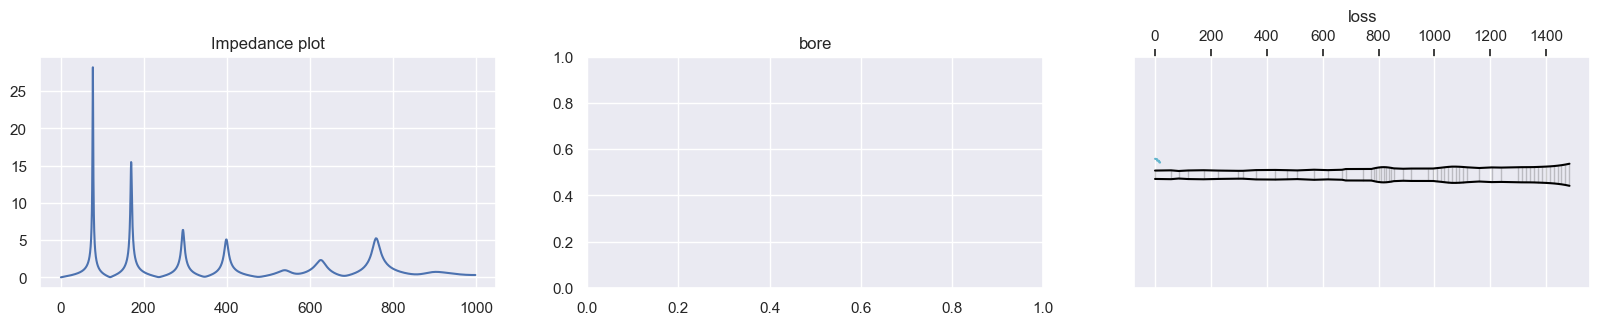

KeyboardInterrupt: 

In [49]:
initial_population = shape.clone()
#initial_population = load_latest_evolution()

evo = Nuevolution(
    loss, 
    initial_population,
    generation_size=100, 
    num_generations=1000,
    population_size=1000)

init_standard_evolution(target_freqs, evo)

population = evo.evolve()